In [37]:
using DataFrames
using Gadfly
using CSV
using HDF5
using MAT
using Optim
using StatsKit
using Random

In [38]:
const fpath = "./machine-learning-ex5/ex5/"
const fname = "ex5data1.mat"

"ex5data1.mat"

In [39]:
file = matopen(fpath * fname)
names(file)
Xtrain = read(file, "X")
ytrain = read(file, "y")
Xval = read(file, "Xval")
yval = read(file, "yval")
Xtest = read(file, "Xtest")
ytest = read(file, "ytest");

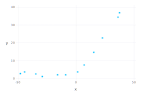

In [40]:
plot(x = Xtrain, y = ytrain, Geom.point)

In [41]:
function linearRegCostFunctionx(Xmat, y, λ = 0)
# returns two pointers to functions cost and gradient
    m = length(y)
    return (weights::Array) -> begin
        l2_penalty = (λ/2m) * (weights[2:end]'weights[2:end])
        errors = Xmat * weights'
        sum_sqrd_errs = sum((errors - y).^2)
        (1/2m) * sum_sqrd_errs + l2_penalty
        end, (weights::Array) -> begin
                penalty = hcat(0.0, (λ/m)* weights[:, 2:end])
                errors = Xmat * weights' - y
                (errors'Xmat)/m + penalty
            end
end

linearRegCostFunctionx (generic function with 2 methods)

In [42]:
function trainLinearReg(Xmat, ymat, λ = 0)
# optimizes using cost and gradient
    cost, gradient = linearRegCostFunctionx(Xmat, ymat, λ)
    initial_θ = zeros(Float64, (1, size(Xmat)[2]))
    optimize(cost, gradient, initial_θ, ConjugateGradient(); inplace = false)
    #optimize(cost, gradient, initial_θ; inplace = false)
end

trainLinearReg (generic function with 2 methods)

In [43]:
function learningCurve(Xmat, ymat, Xvalmat, yvalmat, λ = 0)
# generates learning curves
    cost_train = Array{Float64, 1}(undef, length(ymat))
    cost_valid = Array{Float64, 1}(undef, length(ymat))

    for m in 1:1:size(Xmat)[1]
        res = trainLinearReg(Xmat[1:m,:], ymat[1:m], λ)
        cost_train[m] = Optim.minimum(res)
        cost, gradient = linearRegCostFunctionx(Xvalmat, yvalmat, λ)
        cost_valid[m] = cost(Optim.minimizer(res))
    end
    return cost_train, cost_valid
end

learningCurve (generic function with 2 methods)

In [44]:
# function add a vector of ones to design matrix
addconstant(Xmat) = hcat(ones(size(Xmat)[1]), Xmat)

addconstant (generic function with 1 method)

In [45]:
lambda = 1
c, g = linearRegCostFunctionx(addconstant(Xtrain), ytrain, lambda)
c([1 1]), g([1 1])

(303.9931922202643, [-15.303 598.251])

In [46]:
# compute optimal values. lambda = 0
train_res = trainLinearReg(addconstant(Xtrain), ytrain)
train_coefs = Optim.minimizer(train_res)
train_cost = Optim.minimum(train_res)

22.373906495108915

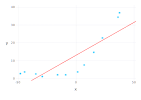

In [47]:
plot(x = Xtrain, y = ytrain, Geom.point,
    intercept = [train_coefs[1]], slope = [train_coefs[2]],
    Geom.abline(color = "red"))

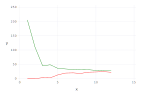

In [48]:
# Plot learning curves
error_train, error_val = learningCurve(addconstant(Xtrain), ytrain,
                                        addconstant(Xval), yval)

line1 = layer(x=collect(1:1:12), y=error_train, Geom.line, Theme(default_color="red"))
line2 = layer(x=collect(1:1:12), y=error_val, Geom.line, Theme(default_color="green"))
plot(line1, line2)

Shows high bias. Both curves are high when the number of training examples is increased (underfitting). One solution is to increase the number of features.

##### Polynomial Features

In [49]:
# function to generate polynomial features of degree p
# the vector is broadcast against each degree

polyFeatures(Xmat, p) = Xmat.^((1:p)')

poly_deg = 8 # use 6 instead of 8 unlike in the assignment to get the curve Figure 4
Xtrain_poly = polyFeatures(Xtrain, poly_deg);

In [50]:
function normalize_features(Xmat)::Tuple{Array, Array}
# Normalizes columns of matrix Xmat
# Returns normalized matrix along with means and sd for each column
    norms = Array{Float64, 2}(undef, size(Xmat)) # store normalized values
    stats = Array{Float64, 2}(undef, (size(Xmat)[2], 2)) # save means and sds

    for idx in 1:1:size(Xmat)[2]
        mean_idx = mean(Xmat[:, idx])
        sd_idx = std(Xmat[:, idx])
        norms[:, idx] = (Xmat[:, idx] .- mean_idx) ./ std(Xmat[:, idx])
        stats[idx, 1] = mean_idx
        stats[idx, 2] = sd_idx
    end
    return norms, stats
end

normalize_features (generic function with 1 method)

In [51]:
Xtrain_poly_norm, Xtrain_poly_stats = normalize_features(Xtrain_poly);

In [52]:
# check means and sd
println(map(c -> mean(Xtrain_poly_norm[:, c]), 1:poly_deg))
println(map(c -> std(Xtrain_poly_norm[:, c]), 1:poly_deg))

[-6.4763e-17, 2.35922e-16, 5.55112e-17, -4.62593e-17, 7.86408e-17, 6.4763e-17, -3.70074e-17, 9.25186e-17]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [53]:
μ = Xtrain_poly_stats[:,1]
σ = Xtrain_poly_stats[:,2];

In [54]:
# normalize validation set
Xvalid_poly = polyFeatures(Xval, poly_deg)
Xvalid_poly_norm = (Xvalid_poly .- μ') ./ σ';

In [55]:
# normalize test set
Xtest_poly = polyFeatures(Xtest, poly_deg)
Xtest_poly_norm = (Xtest_poly .- μ') ./ σ';

In [56]:
# compute optimal values. use default optimize
lambda = 100.0
train_poly_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, lambda)
train_poly_coefs = Optim.minimizer(train_poly_res)
train_poly_fitted = addconstant(Xtrain_poly_norm) * train_poly_coefs';

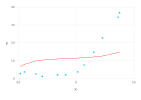

In [57]:
line1 = layer(x = Xtrain, y = ytrain, Geom.point)
line2 = layer(x = Xtrain, y = train_poly_fitted, Geom.line, Theme(default_color="red"))
plot(line1, line2)

In [58]:
Xgrid = collect(minimum(Xtrain) - 15:0.05:maximum(Xtrain) + 25)
Xgrid_poly = polyFeatures(Xgrid, poly_deg)
Xgrid_poly_norm = (Xgrid_poly .- μ') ./ σ'
fitted_Xgrid = addconstant(Xgrid_poly_norm) * train_poly_coefs';

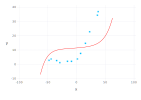

In [59]:
line1 = layer(x = Xtrain, y = ytrain, Geom.point)
line2 = layer(x = Xgrid, y = fitted_Xgrid, Geom.line, Theme(default_color="red"))
plot(line1, line2)

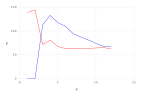

In [60]:
# Plot learning curves
lambda = 100.0
error_poly_train, error_poly_val = learningCurve(addconstant(Xtrain_poly_norm), ytrain,
                                        addconstant(Xvalid_poly_norm), yval, lambda)

line1 = layer(x = collect(1:1:12), y = error_poly_train,
                                        Geom.line, Theme(default_color="blue"))
line2 = layer(x = collect(1:1:12), y = error_poly_val,
                                        Geom.line, Theme(default_color="red"))
plot(line1, line2)

gap between training and validation sets indicates a variance problem

In [61]:
# change lambda (increase) to address problem with variance
lambda_vals = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10];

In [62]:
function validationCurve(Xmat, ymat, Xvalmat, yvalmat)
    return (λ::Float64) -> begin
        results = trainLinearReg(Xmat, ymat, λ)
        coefs_train = Optim.minimizer(results)
        cost_train = Optim.minimum(results)
        cost_val, grd_val = linearRegCostFunctionx(Xvalmat, yvalmat, λ)
        cost_train, cost_val(coefs_train)
    end
end

validationCurve (generic function with 1 method)

In [63]:
errors = validationCurve(addconstant(Xtrain_poly_norm), ytrain,
                addconstant(Xvalid_poly_norm), yval)
errors_λ = errors.(lambda_vals);

In [64]:
train_errs = map(val -> val[1], errors_λ)
valid_errs = map(val -> val[2], errors_λ);

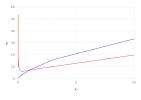

In [65]:
line1 = layer(x = lambda_vals, y = train_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = lambda_vals, y = valid_errs,
                                Geom.line, Theme(default_color="red"))
plot(line1, line2)

In [66]:
best_lambda = lambda_vals[argmin(valid_errs)]

0.3

In [67]:
# Calculate test error for best_lambda
best_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, best_lambda)
best_coefs = Optim.minimizer(best_res)
# use coefs to calculate test error
cost_test, grd_test = linearRegCostFunctionx(addconstant(Xtest_poly_norm), ytest, best_lambda)
cost_test(best_coefs)

6.270666945860224

In [68]:
function learningCurveRandomx(Xmat, ymat, Xvalmat, yvalmat, λ = 0)

    draws = 50
    #num_ex_sampled = 6
    return (num_ex_sampled::Int64) -> begin
        cum_cost_train = 0
        cum_cost_valid = 0
        rng = MersenneTwister(1234)

        for draw in 1:draws
            num_ex_Xmat = size(Xmat, 1)
            ex_train_sampled = rand(rng, 1:num_ex_Xmat, num_ex_sampled)
            res_sampled = trainLinearReg(Xmat[ex_train_sampled, :],
                                            ymat[ex_train_sampled], λ)
            coefs_sampled = Optim.minimizer(res_sampled)
            cost_sampled = Optim.minimum(res_sampled)
            cum_cost_train += cost_sampled

            num_ex_Xvalmat = size(Xvalmat, 1)
            ex_val_sampled = rand(rng, 1:num_ex_Xvalmat, num_ex_sampled)
            cost_val, grd_val = linearRegCostFunctionx(Xvalmat[ex_val_sampled, :],
                                                        yvalmat[ex_val_sampled], λ)
            cum_cost_valid += cost_val(coefs_sampled)
        end # for loop
        cum_cost_train/draws, cum_cost_valid/draws
    end # begin
end # function

learningCurveRandomx (generic function with 2 methods)

In [69]:
lambda = 100
cv_random = learningCurveRandomx(addconstant(Xtrain_poly_norm), ytrain,
                    addconstant(Xvalid_poly_norm), yval, lambda)
errors_random = map(nexamples -> cv_random(nexamples), 1:12);

In [70]:
train_random_errs = map(val -> val[1], errors_random)
valid_random_errs = map(val -> val[2], errors_random)
minimum(valid_random_errs)

67.34611585753417

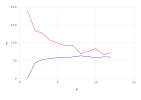

In [71]:
line1 = layer(x = 1:12, y = train_random_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = 1:12, y = valid_random_errs,
                                Geom.line, Theme(default_color="red"))
plot(line1, line2)